# **Telco Churn Report**

### **Christopher Mayorga**

**June, 2021**

### **Why are our customers churning?**

Look for any groupings that indicate a customer is more likely to churn.

### **Executive Summary**

**Findings:**
- Early analysis showed that rate of churn goes down as tenure increases
- Biggest drivers of churn were payment type, contract type, and total charges
- Classification model predicts whether a customer will churn with 78% accuracy

**Recommendations:**
- Offer discounts for automatic payment types and one or two-year contracts
- Run advertising campaign promoting new discounts

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# visualizing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=14)

# preparing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# acquiring
from env import host, user, password, get_db_url

In [2]:
# import helper functions
from acquire import get_telco_data
from prepare import prep_telco_data, prep_telco_data_all

In [3]:
telco = get_telco_data()

In [4]:
# Summarize the dataframe
print(telco.shape)
print(telco.info())

(7043, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 1

In [5]:
# Get summary statistics. This only shows numeric columns.
telco.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000


In [6]:
# What is the overall churn rate?
telco.churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: churn, dtype: float64

# **Prepare Data**

**Columns that need to be encoded:**
- Gender: create new column "is_female" where Female = 1, Male = 0
- Service details (online security, online backup, etc.): Change from Yes/no to 1/0
- Churn: Change from Yes/no to 1/0
- Partner and dependents: Change from Yes/no to 1/0

In [7]:
# Check for missing values
telco.isna().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
payment_type                0
internet_service_type       0
contract_type               0
dtype: int64

### **Split our data**

In [8]:
train, validate, test = prep_telco_data(get_telco_data())

print(f'The shape of the train dataset is: {train.shape}')
print(f'The shape of the validate dataset is: {validate.shape}')
print(f'The shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (3943, 33)
The shape of the validate dataset is: (1691, 33)
The shape of the test dataset is: (1409, 33)


Train is the largest of the three. This will be the dataset used for explorations and modeling before moving on to validate and test.

In [9]:
# Take a look at train dataframe.

train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,contract_type,month_to_month,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned
5707,5605-XNWEN,Male,1,1,0,72,1,1,3,0,...,Two year,0,0,1,0,0,1,0,1,0
4471,4355-CVPVS,Female,0,1,1,56,1,0,2,0,...,One year,0,1,0,0,1,0,1,1,0
4994,3915-ODIYG,Male,1,0,0,60,1,1,1,1,...,One year,0,1,0,1,0,0,0,0,0
3458,6575-SUVOI,Female,1,1,0,25,1,1,1,1,...,Month-to-month,1,0,0,1,0,0,1,1,0
3818,9504-DSHWM,Male,0,0,0,20,1,1,1,1,...,Month-to-month,1,0,0,1,0,0,0,1,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5707 to 6864
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3943 non-null   object 
 1   gender                    3943 non-null   object 
 2   senior_citizen            3943 non-null   int64  
 3   partner                   3943 non-null   int64  
 4   dependents                3943 non-null   int64  
 5   tenure                    3943 non-null   int64  
 6   phone_service             3943 non-null   int64  
 7   multiple_lines            3943 non-null   int64  
 8   internet_service_type_id  3943 non-null   int64  
 9   online_security           3943 non-null   int64  
 10  online_backup             3943 non-null   int64  
 11  device_protection         3943 non-null   int64  
 12  tech_support              3943 non-null   int64  
 13  streaming_tv              3943 non-null   int64  
 14  strea

# **Explore Data**

**Goals:**
- Determine drivers of churn
- Visualize data
- Run statistical tests
- Set the baseline model

**We are only using the `train` dataset for this stage**

## **Step 1: Create a baseline against which we can compare our models.**

To do this, we'll take the most common observations to the question: Did a customer churn?

In [11]:
# Overall churn rate
train.churn.value_counts(normalize=True)

No     0.73472
Yes    0.26528
Name: churn, dtype: float64

The most common observation is no, meaning a customer didn't churn. When testing our models, we should aim to get an accuracy higher than 73%.

## **Step 2: Compare rates of churn across tenure length**

In [12]:
# Create a column 'tenure_in_years' in a separate dataframe
explore_df = train
explore_df['tenure_in_years'] = round(explore_df.tenure / 12)

In [13]:
# Rate of churn for those who have a tenure of 1 year or less:
mask1 = explore_df.tenure_in_years <= 1
one_year = explore_df[mask1]
one_year.churn.value_counts(normalize=True)

No     0.548847
Yes    0.451153
Name: churn, dtype: float64

In [14]:
# Rate of churn for those who have a tenure of 2 years:
mask2 = (explore_df.tenure_in_years > 1) & (explore_df.tenure_in_years <= 2)
two_years = explore_df[mask2]
two_years.churn.value_counts(normalize=True)

No     0.773451
Yes    0.226549
Name: churn, dtype: float64

In [15]:
# Rate of churn for those who have a tenure of 3 years:
mask3 = (explore_df.tenure_in_years > 2) & (explore_df.tenure_in_years <= 3)
three_years = explore_df[mask3]
three_years.churn.value_counts(normalize=True)

No     0.770408
Yes    0.229592
Name: churn, dtype: float64

In [16]:
# Rate of churn for those who have a tenure of greater than 3 years:
mask4 = (explore_df.tenure_in_years > 3)
more_years = explore_df[mask4]
more_years.churn.value_counts(normalize=True)

No     0.892196
Yes    0.107804
Name: churn, dtype: float64

**Takeaways:**
- As tenure increases, churn decreases
- Highest amount of churn ('Yes' value counts) is in 1 year or less

## **Step 3: Visualize data**

Does monthly charges indicate whether or not someone churns? 
- Maybe. It seems like those who churned have higher monthly charges.

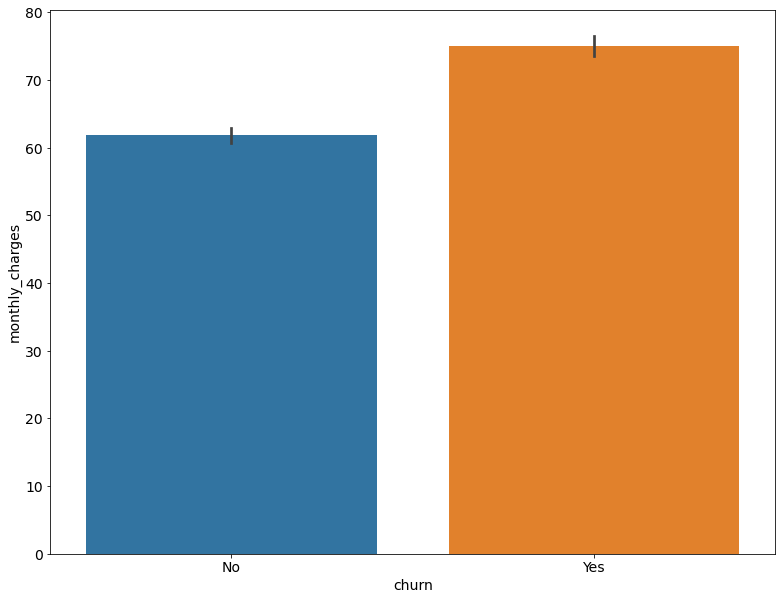

In [17]:
sns.barplot(x = 'churn', y = 'monthly_charges', data = train)
plt.show()

Does automatic payment type indicate whether or not someone churns? 
- Probably. It seems like those who churned have a lower chance of using an automatic payment type.

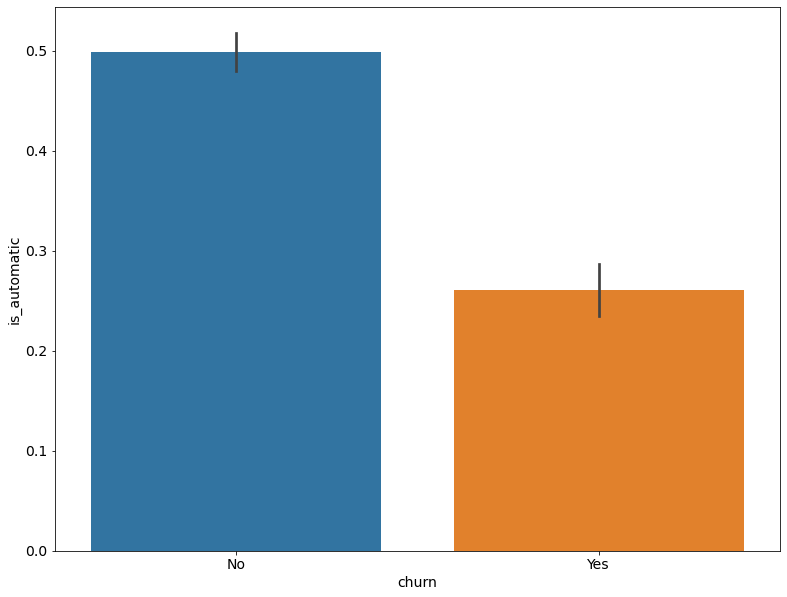

In [18]:
sns.barplot(x = 'churn', y = 'is_automatic', data = train)
plt.show()

What if we add another dimension--contract type?
- There seems to be quite a difference across contract types, indicating this might be a variable we'd want to test.

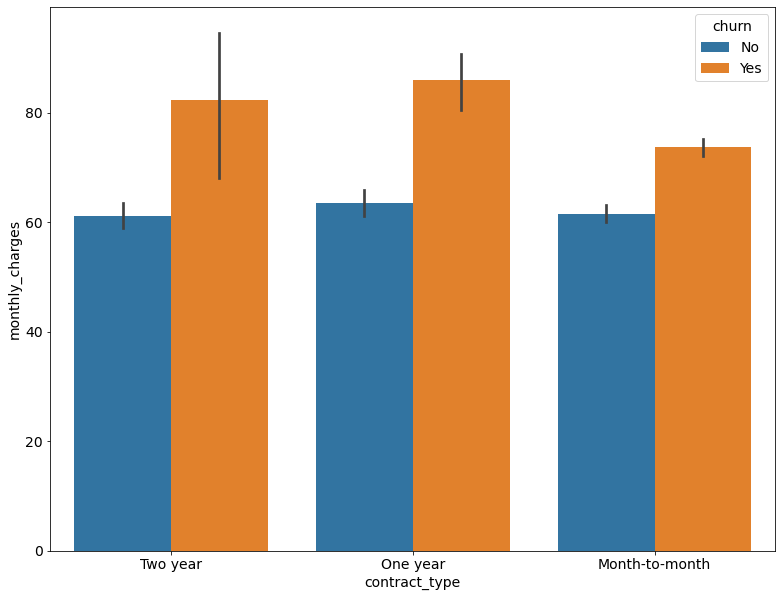

In [19]:
sns.barplot(x = 'contract_type', y = 'monthly_charges', hue = 'churn', data = train)
plt.show()

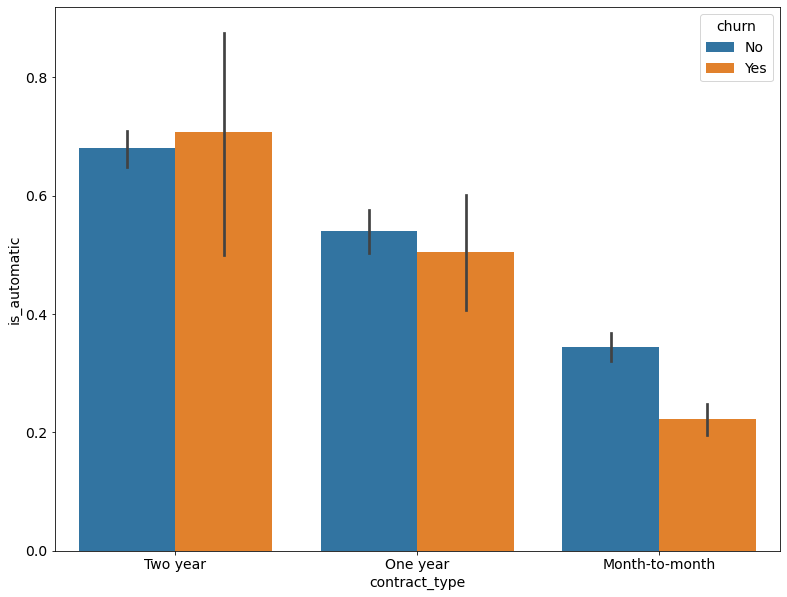

In [20]:
sns.barplot(x = 'contract_type', y = 'is_automatic', hue = 'churn', data = train)
plt.show()

When we divide the data by automatic payment type, it seems like there are many more who churned among those who do not have an automatic payment type.

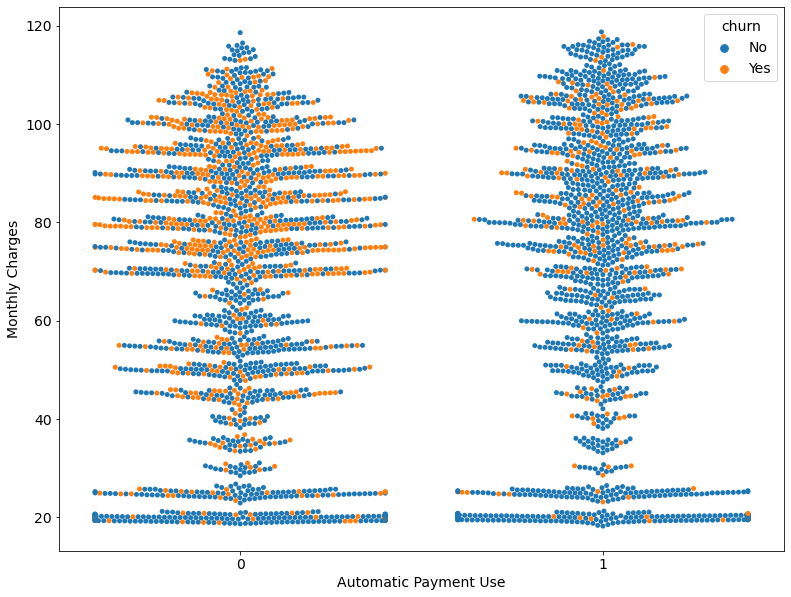

In [21]:
sns.swarmplot(x = 'is_automatic', y = 'monthly_charges', data = train, hue = 'churn')
plt.xlabel("Automatic Payment Use")
plt.ylabel("Monthly Charges")
plt.show()

**Takeaway:**
- Run a statistical test to see if automatic payment type is a driver of churn.

What if we make a heatmap showing correlation between variables and whether or not they churned?

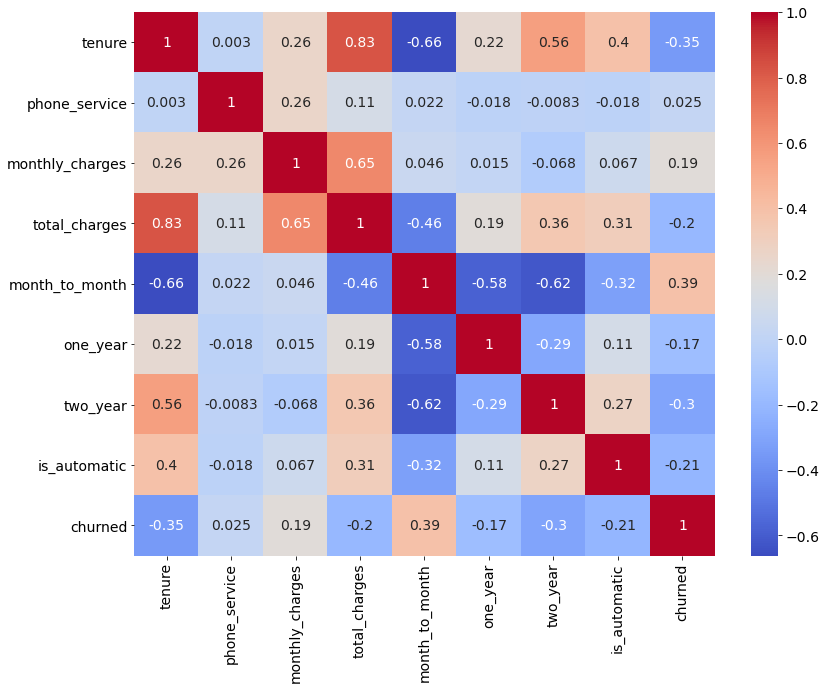

In [22]:
heatmap_columns = ['tenure', 'phone_service', 'monthly_charges', 'total_charges', 'month_to_month', 'one_year', 
                   'two_year', 'is_automatic', 'churned']

corr = explore_df[heatmap_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Takeaway:**
- Month-to-month had the highest correlation with churn -> Run a statistical test for contract type

## **Step 4: Hypothesis testing**

**Hypothesis 1:**
- $H_0$: There is no relationship between contract type and customer churn.
- $H_a$: There is a relationship between contract type and customer churn.

In [23]:
# Set confidence level and alpha
confidence_level = 0.95
alpha = 0.05

In [24]:
# Create crosstab
crosstab1 = pd.crosstab(explore_df.churn, explore_df.contract_type)
crosstab1

contract_type,Month-to-month,One year,Two year
churn,,,
No,1269,730,898
Yes,919,103,24


In [25]:
# Two categorical variables --> chi^2 test

chi2, p, degf, expected = stats.chi2_contingency(crosstab1)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

p-value is: 1.655e-136
chi2 value is: 625.3
Our p-value is less than our alpha, thus the null hypothesis is rejected.


**Hypothesis Test 1 Result**
- We rejected our null hypothesis, indicating there is some relationship between contract type and churn.

**Hypothesis 2:**
- $H_0$: There is no relationship between automatic payment type and customer churn.
- $H_a$: There is a relationship between automatic payment type and customer churn.

In [26]:
# Set confidence level and alpha
confidence_level = 0.95
alpha = 0.05

In [27]:
# Create crosstab
crosstab2 = pd.crosstab(explore_df.churn, explore_df.is_automatic)
crosstab2

is_automatic,0,1
churn,,
No,1454,1443
Yes,773,273


In [28]:
# Two categorical variables --> chi^2 test

chi2, p, degf, expected = stats.chi2_contingency(crosstab2)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

p-value is: 6.579e-40
chi2 value is: 174.8
Our p-value is less than our alpha, thus the null hypothesis is rejected.


**Hypothesis Test 2 Result:**
- We rejected our null hypothesis, indicating there is some relationship between automatic payment type and churn.

## **Step 5: Modeling**

We will use logistic regression, decision tree, and random forest models.

Recall that our baseline stands at 73%.

**First we are defining our features (X-variable) and target (churn). Features were derived from visualizations and statistical testing.**

In [29]:
X_cols = ['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']
y_col = 'churned'

X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]

## Train

### Model 1: Logistic Regression

In [30]:
# Create the model
logit = LogisticRegression(C = 1.0, random_state=123)

# Fit the model
logit.fit(X_train, y_train)

# Print out coefficients and intercepts
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

# Use the model to create predictions
y_pred1 = logit.predict(X_train)

# Probability of churning
y_pred_prob1 = logit.predict_proba(X_train)

print(f'Accuracy score: {logit.score(X_train, y_train):.2%}')

Coefficient: 
 [[-3.70970579e-01  1.78421421e-01 -7.47182062e-01 -1.75697263e+00
   3.64956082e-02 -3.78711048e-04]]
Intercept: 
 [-2.38076041]
Accuracy score: 79.13%


In [31]:
cr = pd.DataFrame(classification_report(train.churned, y_pred1, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.830465,0.638509,0.791276,0.734487,0.779543
recall,0.899551,0.491396,0.791276,0.695474,0.791276
f1-score,0.863629,0.555375,0.791276,0.709502,0.781855
support,2897.000000,1046.000000,0.791276,3943.000000,3943.000000


**Takeaways:**
- This model performed better than the baseline (73%), with an accuracy of 79%
- Based on the coefficients, one_year had the highest (negative) weight, followed by is_automatic and total_charges

### Model 2: Decision Tree

In [32]:
# Create the model
dt = DecisionTreeClassifier(max_depth=5, random_state=123)

# Fit the model
dt.fit(X_train, y_train)

# Use the model to create predictions
y_pred2 = dt.predict(X_train)

# Probability of churning
y_pred_prob2 = dt.predict_proba(X_train)

print(f'Accuracy score: {dt.score(X_train, y_train):.2%}')

Accuracy score: 80.27%


In [33]:
cr = pd.DataFrame(classification_report(train.churned, y_pred2, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.844329,0.654734,0.802688,0.749532,0.794033
recall,0.896790,0.542065,0.802688,0.719427,0.802688
f1-score,0.869769,0.593096,0.802688,0.731433,0.796373
support,2897.000000,1046.000000,0.802688,3943.000000,3943.000000


**Takeaways:**
- Accuracy is slightly higher than logistic regression model
- Recall is slightly higher

### Model 3: Random Forest

In [34]:
# Create the model
rf = RandomForestClassifier(bootstrap=True,
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=20, 
                            random_state=123)

# Fit the model
rf.fit(X_train, y_train)

# Use the model to create predictions
y_pred3 = rf.predict(X_train)

# Probability of churning
y_pred_prob3 = rf.predict_proba(X_train)

print(f'Accuracy score: {rf.score(X_train, y_train):.2%}')

Accuracy score: 84.10%


In [35]:
cr = pd.DataFrame(classification_report(train.churned, y_pred3, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.861926,0.759603,0.840984,0.810765,0.834782
recall,0.933034,0.586042,0.840984,0.759538,0.840984
f1-score,0.896072,0.661630,0.840984,0.778851,0.833879
support,2897.000000,1046.000000,0.840984,3943.000000,3943.000000


**Takeaways:**
- Performs better on all metrics than previous two models
- Lower interpretability, could be more difficult to replicate

## Validate

We will take our top two performing models (decision tree and random forest) and apply them to our validate data. This will help us determine which one we should use on the test data.

### Decision Tree Validation

In [36]:
# Use the model to create predictions
y_pred_validate1 = dt.predict(X_validate)

# Probability of churning
y_pred_prob_validate1 = dt.predict_proba(X_validate)

print(f'Accuracy score: {dt.score(X_validate, y_validate):.2%}')

Accuracy score: 77.47%


In [37]:
cr = pd.DataFrame(classification_report(validate.churned, y_pred_validate1, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.824906,0.592896,0.77469,0.708901,0.763302
recall,0.880032,0.483296,0.77469,0.681664,0.774690
f1-score,0.851578,0.532515,0.77469,0.692047,0.766859
support,1242.000000,449.000000,0.77469,1691.000000,1691.000000


### Random Forest Validation

In [38]:
# Use the model to create predictions
y_pred_validate2 = rf.predict(X_validate)

# Probability of churning
y_pred_prob_validate2 = rf.predict_proba(X_validate)

print(f'Accuracy score: {rf.score(X_validate, y_validate):.2%}')

Accuracy score: 79.18%


In [39]:
cr = pd.DataFrame(classification_report(validate.churned, y_pred_validate2, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.831595,0.638968,0.791839,0.735282,0.780448
recall,0.898551,0.496659,0.791839,0.697605,0.791839
f1-score,0.863777,0.558897,0.791839,0.711337,0.782824
support,1242.000000,449.000000,0.791839,1691.000000,1691.000000


**Takeaways:**
- Performance between two models is much more similar in validate stage
- Decision tree accuracy dropped about 3 percentage points, while random forest dropped about 5 percentage points

## Test

Our decision tree model has the lowest drop in accuracy between train and validate. It is also the easiest to explain. We'll run ONLY this model through the test data.

In [40]:
# Use the model to create predictions
y_pred_test = dt.predict(X_test)

# Probability of churning
y_pred_prob_test = dt.predict_proba(X_test)

print(f'Accuracy score: {dt.score(X_test, y_test):.2%}')

Accuracy score: 78.92%


In [41]:
cr = pd.DataFrame(classification_report(test.churned, y_pred_test, output_dict=True))
cr

,0,1,accuracy,macro avg,weighted avg
precision,0.830054,0.632302,0.789212,0.731178,0.777563
recall,0.896618,0.491979,0.789212,0.694298,0.789212
f1-score,0.862053,0.553383,0.789212,0.707718,0.780121
support,1035.000000,374.000000,0.789212,1409.000000,1409.000000


We can see how our model did by looking at the confusion matrix.

In [42]:
pd.crosstab(test.churned, y_pred_test, margins=True, normalize=True)

col_0,0,1,All
churned,,,
0,0.658623,0.075940,0.734564
1,0.134847,0.130589,0.265436
All,0.793471,0.206529,1.000000


## **Step 6: Predicting Churn**

In [43]:
reset_test = test.reset_index()

In [44]:
test_proba_df = pd.DataFrame(y_pred_prob_test, columns=['no_churn', 'churn_prob'])

In [45]:
test_proba_df

,no_churn,churn_prob
0,0.900000,0.100000
1,0.933333,0.066667
2,0.940789,0.059211
3,0.692308,0.307692
4,0.702439,0.297561
...,...,...
1404,0.350000,0.650000
1405,0.824000,0.176000
1406,0.917808,0.082192
1407,0.350000,0.650000


In [46]:
test_proba_df = pd.concat([reset_test, test_proba_df['churn_prob']], axis=1)

In [47]:
test_proba_df['predicted'] = y_pred_test

In [48]:
test_proba_df

,index,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned,churn_prob,predicted
0,3960,2592-HODOV,Male,0,0,0,13,1,0,3,...,1,0,0,0,1,0,1,0,0.100000,0
1,2131,7426-GSWPO,Male,1,0,0,64,1,1,2,...,0,0,0,1,0,0,1,0,0.066667,0
2,5313,9378-FXTIZ,Female,0,1,0,54,1,1,1,...,1,0,1,0,0,1,1,1,0.059211,0
3,4295,1017-FBQMM,Female,0,1,1,62,1,1,2,...,1,0,0,1,0,1,1,0,0.307692,0
4,772,1193-RTSLK,Female,0,0,0,38,1,0,2,...,0,0,0,1,0,1,1,1,0.297561,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,879,1731-TVIUK,Female,0,0,0,4,1,1,2,...,0,0,0,1,0,1,0,1,0.650000,1
1405,4486,4628-WQCQQ,Male,0,0,1,35,1,0,2,...,1,0,0,1,0,0,0,1,0.176000,0
1406,6227,5887-IKKYO,Male,0,1,1,58,1,1,2,...,0,1,0,1,0,0,1,0,0.082192,0
1407,3258,4931-TRZWN,Female,0,0,0,13,1,0,1,...,0,0,1,0,0,1,0,0,0.650000,1


In [49]:
csv = test_proba_df[['customer_id', 'predicted', 'churn_prob']]

In [50]:
csv

,customer_id,predicted,churn_prob
0,2592-HODOV,0,0.100000
1,7426-GSWPO,0,0.066667
2,9378-FXTIZ,0,0.059211
3,1017-FBQMM,0,0.307692
4,1193-RTSLK,0,0.297561
...,...,...,...
1404,1731-TVIUK,1,0.650000
1405,4628-WQCQQ,0,0.176000
1406,5887-IKKYO,0,0.082192
1407,4931-TRZWN,1,0.650000


In [51]:
# Write DataFrame to a csv for deliverable.

csv.to_csv('predictions.csv')

In [52]:
csv.predicted.value_counts()

0    1118
1     291
Name: predicted, dtype: int64

**There would be 291 customers who churn out of the test dataset.**

## **Conclusions**

- Our baseline model was set at 73%
- Our decision tree model was ran through train, validate, and test datasets, consistently performing better than the baseline
- Our model predicted 291 customers would churn out of the test dataset
- Whether or not someone has an automatic payment type and the contract type were good predictors of churn
- **Recommendation:** Offer discounts to those who sign up for an automatic payment type or a 1-2 year contract

**Next steps:**
- Test out the model on out of sample data to see how well it performs in the wild